In [1]:
import pandas as pd
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gzip 
import math
import itertools
from time import time
from tqdm import tqdm
import tqdm.notebook as tq
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os
import vec_tools
import word_tools
import statistics
from nltk.corpus import stopwords
import random

# Create/load domains

In [2]:
lst_dir =  "G:/My Drive/KU/Thesis/data/domains/" 
domain_dic = {}

garg_lists = ["occupations1950.txt", "adjectives_appearance.txt",  'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt', 'adjectives_otherization.txt', 'adjectives_princeton.txt',
 'adjectives_sensitive.txt', 'adjectives_williamsbest.csv', 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt', 'occupations1950_professional.txt']

for dic in garg_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/garg/{dic}", encoding="utf-8").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]

wiki_lists = ['music_genres','lit_genres','us_cities','uk_cities',
               'countries','hobbies','subcultures'] #sports
for lst in wiki_lists:
    domain_dic[lst] = word_tools.load_list(f"{lst_dir}/wiki/{lst}_wiki.txt")
    
manual_lists = [ 'virtues.txt', 'vices.txt', 'genres.txt', 'emotions.txt', 'housing.txt',
 'clothing.txt', 'white_trash.txt', 'old_rich.txt', 'new_rich.txt', 'u.txt', 'new_u.txt', 'non_u.txt',
 'refined.txt', 'sports.txt', 'unrefined.txt', 'art_movs.txt', 'Subcultures.txt', 'places-of-entertainment.txt',
                'vehicles.txt']
for dic in manual_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/domains/{dic}").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]
domain_dic.keys()

domain_dic["goc_genres"] = ["hiphop", "rap", "bluegrass", "opera", "jazz", "techno", "punk"]
domain_dic["all_cult"] = {"Vehicles":domain_dic["vehicles"],"Housing":domain_dic["housing"], "Occupation": domain_dic["occupations1950"], "Clothing":domain_dic["clothing"], "Places of Entertainment":domain_dic["places-of-entertainment"], "Music":domain_dic["goc_genres"], "Sport":domain_dic["sports"]}
#"goc_genres", "art_movs", "hobbies", "genres", "emerging_traditional_genres", "housing"

In [3]:
groups =['Iso_occupations.xlsx','standard_occupations_uk_incomplete.xlsx','occupations_1950_categorised.xlsx','vices_virtues.xlsx','u_non_u.xlsx','old_rich_new_rich.xlsx','emerging_traditional_genres.xlsx', 'goc_culture_domains.xlsx']
os.chdir("G:/My Drive/KU/Thesis/data/domains/dicts/")
os.listdir()
for group in groups: 
    domain_dic[group[:-5]] = vec_tools.load_domain_dic(f"G:/My Drive/KU/Thesis/data/domains/dicts/{group}")
   

# Almighty iterator

In [4]:
class AllDecsIterator():
    def __init__(self, coll, dims, kv, test=False):
        self.coll = coll
        self.dims = dims
        self.stereotypes = {}
        self.test=test
        self.kv = kv
        
    def iterate(self):
        self.input_dir = f"D:/google_ngrams/vectors/{coll}/"
        decades_dict = OrderedDict()
        if self.test == True:
            rng = 2
        else: 
            rng = 10
        for i in range(rng):
            decades_dict[str(1900+10*i)] = str(1900+10*i)+'_model'
        self.wvs = vec_tools.load_wvs(decades_dict, self.input_dir, kv=self.kv)
        self.ants = {dec : {} for dec, val in self.wvs.items()}
        self.projs = {dec : {} for dec, val in self.wvs.items()}
        self.dim_vecs = {dec : {} for dec, val in self.wvs.items()}
        self.angles = {dec : {} for dec, val in self.wvs.items()}
        self.norm_matrix = {dec : {} for dec, val in self.wvs.items()}
        self.stereotypes = {dec : {} for dec, val in self.wvs.items()}
        
        for dec, wv in self.wvs.items():
            matrix = wv.get_normed_vectors()
            self.norm_matrix[dec] = vec_tools.normify_matrix(matrix)

            for dim in self.dims:
                self.ants[dec][dim] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{dim}_antonyms_goc.csv", header = 0, names = ("pos_ant", "neg_ant"))
                self.ants[dec][dim] = self.ants[dec][dim].rename(columns= {"pos_ant":self.ants[dec][dim].iloc[0,0],"neg_ant":self.ants[dec][dim].iloc[0,1]})
                print(self.ants[dec][dim])
                self.dim_vecs[dec][dim] = vec_tools.create_dim_avg(wv, self.ants[dec][dim])
                self.projs[dec][dim] = vec_tools.proj_dim(self.dim_vecs[dec][dim], self.norm_matrix[dec])
               # print(dec, dim, self.projs[dec][dim])
            
            #Calculate angles between dimensions per decade
            self.angles[dec] = {dim : {} for dim in self.dims}
            for dim1 in self.dims:
                for dim2 in self.dims:
                    angle = vec_tools.vector_angle(self.dim_vecs[dec][dim1], self.dim_vecs[dec][dim2])
                    self.angles[dec][dim1][dim2] = angle
            self.angles[dec] = pd.DataFrame(self.angles[dec])
    
    def stability_through_time(self, n=50):
        '''Retuns dictionary of dictionaries that shows the difference the average of
        the distances between each stop word for each decade'''
        
        print("Calculating stability through time...")
        words = ["f_words", "rand_words"]
        w_lists = {}
        
        w_lists["f_words"] =  stopwords.words('english')
        self.vocab_size = self.norm_matrix["1900"].shape[0]
        rand_inds = [random.randint(0, self.vocab_size) for i in range(n)]
        rand_words = [self.wvs["1900"].index_to_key[ind] for ind in rand_inds]
        w_lists["rand_words"] = []
        for word in rand_words:
            for dec, wv in self.wvs.items():
                try:
                    vec = wv[word]
                except:
                    break
            w_lists["rand_words"].append(word)
        
        dists = {}
        avg_dists = {}
        diffs = {}
        for w_list in words:
            dists[w_list] = {}
            avg_dists[w_list] = {}
            for dec, wv in self.wvs.items():
                dists[w_list][dec] = {}
                for i, fword_1 in enumerate(w_lists[w_list]):
                    dists[w_list][dec][fword_1] = {}
                    for fword_2 in w_lists[w_list][i:]:
                        try:
                            wv_1, wv_2 = wv[fword_1], wv[fword_2]
                            dist = np.linalg.norm(wv_1 - wv_2)
                            dists[w_list][dec][fword_1][fword_2] = dist
                        except:
                            continue
                #avg_dists[dec] = np.mean(dists[dec].values)
            diffs[w_list] = {dec: {} for dec, wv in self.wvs.items()}
            for dec_1, wv in self.wvs.items():
                for dec_2, wv in self.wvs.items():
                    diffs[w_list][dec_1][dec_2] = []
                    for i, fword_1 in enumerate(w_lists[w_list]):
                        for fword_2 in w_lists[w_list][i:]:
                            try:
                                diffs[w_list][dec_1][dec_2].append(abs(dists[w_list][dec_2][fword_1][fword_2] - dists[w_list][dec_1][fword_1][fword_2]))
                            except:
                                continue
                    diffs[w_list][dec_1][dec_2] = np.mean(diffs[w_list][dec_1][dec_2])
        #df = pd.DataFrame()
        diffs["f_words"] = diffs["f_words"]["1900"]
        diffs["rand_words"] = diffs["rand_words"]["1900"]
        return pd.DataFrame(diffs) 
    
    def avg_distance(self, n=50): #e.g. self.norm_matrix["decade"]
        print("Calculating average distance...")
        self.dists = {dec:[] for dec, wv in self.wvs.items()}
        for dec, norm_matrix in self.norm_matrix.items():
            rand_inds = [random.randint(0, norm_matrix.shape[0]) for i in range(n)]
            for ind_1 in rand_inds:
                for ind_2 in rand_inds:
                    self.dists[dec].append(np.linalg.norm(norm_matrix[ind_1] - norm_matrix[ind_2]))
            self.dists[dec] = [el for el in self.dists[dec] if not pd.isna(el)]
            self.dists[dec] = statistics.mean(self.dists[dec])
        self.dists = pd.DataFrame(self.dists, index=["Mean distance"])
        return self.dists
             
    def stereotype_through_time(self, word, word_list=[], type="tag", select="a", selectn=10, topn= 100): #INCOMPLETE
        '''wvs is an ordered dict, domain_list is a list of words, type is type of tagging, 
        select is specifics of tag'''
        self.stereotypes[word] = {}
        if type == "tag":
            df = {}
            for decade, wv in self.wvs.items():
                df[decade] = {i: "" for i in range(selectn)}
                sims = vec_tools.most_similar_tag(word, wv, vec_tools.wn_tagger, topn=topn, selectn=selectn, select=select)
                for i,sim in enumerate(sims):  
                    df[decade][i] = sim
        elif type == None: 
            df= {}
            for decade, wv in self.wvs.items():
                df[decade] = {i: "" for i in range(selectn)}
                sims = vec_tools.most_similar_wlist(word, wv, word_list=False, topn=topn, selectn=selectn)
                for i,sim in enumerate(sims):  
                    df[decade][i] = sim[0]
        else:
            df= {}
            for decade, wv in self.wvs.items():
                df[decade] = {i: "" for i in range(selectn)}
                sims = vec_tools.most_similar_wlist(word, wv, word_list, topn=topn, selectn=selectn)
                for i,sim in enumerate(sims):  
                    df[decade][i] = sim[0]
        df = pd.DataFrame(df)
        self.stereotypes[word] = df
    
    def word_charts_through_time(self, domain, domain_dic, dim_1, dim_2, dom_type="word_list", title=False):
        '''dims = list of two strings which refer to dimensions to be projected on'''
        try:
            os.makedirs(f"G:/My Drive/KU/Thesis/Outputs/Graphs/{domain}_{dim_1}_{dim_2}")
        except Exception as e:
            pass
        #Get stats on projections to align output graphs with one another
        data_projs = {dim_1: [], dim_2: []}
        stats = ["min", "max", "mean", "median", "variance", "dev"]
        chart_vals = {stat : {dim: 0 for dim in [dim_1, dim_2]} for stat in stats}
                      
        if dom_type == "word_dict":
              #  print(domain_dic[domain])
            word_list = [word for cat in domain_dic[domain].keys() for word in domain_dic[domain][cat]]
        else:
            word_list = [word for word in domain_dic[domain]]
                     
        for dim in [dim_1, dim_2]:
            for dec, wv in self.wvs.items():
                for word in word_list: 
                    try:
                        ind = wv.get_index(word.lower())
                        proj = self.projs[dec][dim][ind]
                        data_projs[dim].append(proj)
                    except Exception as e:
                        pass
                #data_projs[dim][dec] = [val for val in data_projs[dim][dec] if np.isnan(val)==False] 
                #chart_vals["min"][dim][dec] = min(data_projs[dim][dec])
                #chart_vals["max"][dim][dec] = max(data_projs[dim][dec])
                #chart_vals["median"][dim][dec] = statistics.median(data_projs[dim][dec])
                #chart_vals["mean"][dim][dec] = statistics.mean(data_projs[dim][dec])
                #chart_vals["variance"][dim][dec] = np.var(data_projs[dim][dec])
            df = data_projs
            chart_vals["min"][dim] = min(df[dim])
            chart_vals["max"][dim] = max(df[dim])
            chart_vals["median"][dim] = statistics.median(df[dim])
            chart_vals["mean"][dim] = statistics.mean(df[dim])
            chart_vals["variance"][dim] = np.var(df[dim])
        #Generate a chart for each decade
        for dec, wv in self.wvs.items():
            if not title:
                try:
                    os.mkdirs(f"G:/My Drive/KU/Thesis/Outputs/Graphs/{domain}_{dim_1}_{dim_2}/")
                except:
                    pass
                fname = f"G:/My Drive/KU/Thesis/Outputs/Graphs/{domain}_{dim_1}_{dim_2}/{self.coll}_{dec}.png"
            dim1_label = self.ants[dec][dim_1].columns[1] + " <------ " + dim_1 + " ------> " + self.ants[dec][dim_1].columns[0]
            dim2_label = self.ants[dec][dim_2].columns[1] + " <------ " + dim_2 + " ------> " + self.ants[dec][dim_2].columns[0]
            if dom_type == "word_dict":
                vec_tools.chart_project_dict(proj_1=self.projs[dec][dim_1], 
                                    p1_label=dim1_label, 
                                    proj_2=self.projs[dec][dim_2], 
                                    p2_label=dim2_label,
                                    title=fname, 
                                    domain_dic=domain_dic[domain], 
                                    wv=wv, 
                                    show=False,
                                    dim_1_span=(chart_vals["min"][dim_1],chart_vals["max"][dim_1]), 
                                    dim_2_span= (chart_vals["min"][dim_2],chart_vals["max"][dim_2]))
                                 #  dim_1_span=(chart_vals["min"][dim_1]["overall"],chart_vals["max"][dim_1]["overall"]), 
                                  #                 dim_2_span= (chart_vals["min"][dim_2]["overall"],chart_vals["max"][dim_2]["overall"]))
          
            else:
                vec_tools.chart_project(proj_1=self.projs[dec][dim_1], 
                                        p1_label=dim1_label, 
                                        proj_2=self.projs[dec][dim_2], 
                                        p2_label=dim2_label,
                                        title=fname, 
                                        word_list=domain_dic[domain], 
                                        wv=wv, 
                                        show=False,
                                       dim_1_span=(chart_vals["min"][dim_1],chart_vals["max"]), 
                                                   dim_2_span= (chart_vals["min"][dim_2],chart_vals["max"][dim_2]))
    def chart_iterate(self, dims, doms, domain_dic, dom_type):
        for i, dim_1 in enumerate(dims):
            for dim_2 in dims_of_interest[i+1:]:
                for domain, word_list in domain_dic.items():
                    if domain not in doms:
                        continue
                    print(f"Charting domain {domain} against dims ({dim_1} x {dim_2})")
                    self.word_charts_through_time(domain=domain, domain_dic=domain_dic, dom_type=dom_type, dim_1=dim_1, dim_2=dim_2, title=False)
                # print(f"{fname} SAVED")


In [81]:
#pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/employer_antonyms_goc_prev.csv", header = 0, sep = ";").set_index("index").to_csv("employer_antonyms_goc.csv")
pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/employer_antonyms_goc.csv", header = 0, sep = ";")

,"index,employer,employee"
0,"0,employer,employee"
1,"1,employers,employees"
2,"2,owner,worker"
3,"3,owners,workers"
4,"4,industrialist,laborer"
5,"5,industrialists,laborers"
6,"6,proprietor,employee"
7,"7,proprietors,employees"
8,"8,capitalist,proletarian"
9,"9,capitalists,proletariat"


In [5]:
coll = "histwords_engall"#"gb_12_18_02"#
#input_dir = f"D:/google_ngrams/vectors/{coll}"
dims = ["affluence", "cultivation", "status", "gender", "race", "morality", "education", "employer"]
histwords_iter = vec_tools.AllDecsIterator(coll, dims, kv=True, test=False)
histwords_iter.iterate()
#dists = iterator.stability_through_time()
#iterator.avg_distance(n=50)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:161: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
G:\My Drive\KU\Thesis\vec_tools.py:152: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot)


## Chart through time

In [ ]:
dims_of_interest = ["affluence",  "cultivation" ,"status"]#"race",
#domains: 
groups_of_interest = ["Iso_occupations"]
doms_of_interest = ["goc_genres", "occupations1950", "clothing", "emotion", "housing", "sports", "popular-music-types", "emotions", "genres", "places of entertainment", "types-of-vehicle"]
histwords_iter.chart_iterate(dims = dims_of_interest, doms=groups_of_interest, domain_dic=domain_dic, dom_type="word_dict")
#for i, dim_1 in enumerate(dims_of_interest):
 #   for dim_2 in dims_of_interest[i+1:]:
  #      for domain, word_list in domain_dic.items():
   #         if domain not in groups_of_interest:
    #            continue
     #       print(f"Charting domain {domain} against dims ({dim_1} x {dim_2})")
      #      iterator.word_charts_through_time(domain=domain, dom_type="word_dict", dim_1=dim_1, dim_2=dim_2, title=False)
#coha_all_decs.word_charts_through_time(word_list=word_list, dim_1="affluence", dim_2="gender", title="occupations")

## Stereotype through time

In [ ]:
stereos = {}
dims
#for occ in domain_dic["occupations1950"]:
   # histwords_iter.stereotype_through_time(occ, word_list=[], type="tag", select="a", selectn=10, topn= 100): 


In [ ]:
occs = ["executive", "manager", "director", "leader", "president", "coach", "boss", "chief", "ceo"]
u = ["consultant", "adviser", "advisor", "customer", "entrepreneur", "expert"]
ns_words = ["network", "networks", "networking", 
         "innovation", "innovative", "innovate", "create", "creative", "creativity", 
         "inspiration", "inspire", "inspirational", "genius", "invent", "inventor", 
         "disruptive", "bureaucracy", "bureaucrat", "decentralized",
         'decentralization','meritocracy','objectives','cadres','networks','project','vision', #projective city
          'streamlined','slimmed','lean','leader','reengineering','flexible','innovative', "communicative",
          'proficient','manager','coach','catalyst','visionary','inspriation','expert','operatives',
          'toyotism','outward','fulfilment','autonomy','discovery','enrichment','learning','spontaneity',
          'spectacle','reticular','alliance',
         'Engaged','Engaging','Mobile','Enthusiastic','Involved','Flexible', #cond great man
         'Adaptable','Versatile','Employable','Autonomous','Tolerant']
["adjectives_appearance.txt",  'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt', 'adjectives_otherization.txt', 'adjectives_princeton.txt',
 'adjectives_sensitive.txt', 'adjectives_williamsbest.csv', 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt']

occ = "business"
wl = domain_dic["personalitytraits_original"]# domain_dic["vices"] + domain_dic["virtues"]
histwords_iter.stereotype_through_time(occ, word_list=wl, type="word_list", select="a", selectn=30, topn= 5000)
histwords_iter.stereotypes[occ]
for dec, wv in histwords_iter.wvs.items():
    print(dec, vec_tools.vector_angle(wv["executive"], wv["manager"]))

In [ ]:
import string
ws = []
h = " Engaged, Engaging, Mobile, Enthusiastic, Involved, Flexible, Adaptable, Versatile, Employable, Autonomous, Tolerant, Employabilit"
for w in h.split():
    for i,l in enumerate(w):
        if l in string.punctuation:
            ws.append(w[:i])
            i = True
            break
    if i == False:
        ws.append(w)
        continue
    i = False
ws
    

In [ ]:
vec_tools.most_similar_tag(word, wv, vec_tools.wn_tagger, topn=100, selectn=selectn, select=select)

In [ ]:
import vec_tools
vec_tools.most_similar_wlist("executive", wv, word_list=wl, dim=False, topn=10000, selectn=10)

In [ ]:
word = "artist"
histwords_iter.stereotype_through_time(word, type="word_list", word_list=domain_dic["personalitytraits_original"], selectn=20, topn= 1000)
histwords_iter.stereotype_through_time(word, type="word_list", word_list=ns_words, selectn=30, topn= 10000)
histwords_iter.stereotypes[word]

In [ ]:
histwords_iter.norm_matrix["1990"].shape

In [ ]:
domain_dic["Iso_occupations"].keys()

In [ ]:
self = histwords_iter
word = "network"
wlist = domain_dic["Iso_occupations"]["Professional"]

wlist_projs  = {dim: {dec: [] for dec, wv in self.wvs.items()} for dim in self.dims}
word_projs = {dim: {} for dim in self.dims}
for dec, wv in self.wvs.items():
    for dim in self.dims:
        for word in wlist: 
            ind = wv.get_index(word.lower())
            proj = self.projs[dec][dim][ind]
            if pd.isna(proj):
                continue
            wlist_projs[dim][dec].append(proj)
           # print(dec, dim, word, proj)
        wlist_projs[dim][dec] = np.mean(wlist_projs[dim][dec])
        ind = wv.get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[dim][dec] = proj
df = pd.DataFrame(wlist_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
df.plot.line()
df.unstack()

In [ ]:
word_list = domain_dic["occupations1950"][:7]
word_projs = {word: {} for word in word_list}
year_1, year_2 = ["1900", "1990"]
dim = "affluence"

for dec in [year_1, year_2]:
    for word in word_list:
        ind = self.wvs[dec].get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[word][dec] = proj
df = pd.DataFrame(word_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
df.plot.line()
#df.unstack()

In [ ]:
self.wvs

In [ ]:
import plotly.express as px
px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)

In [ ]:
n = pd.DataFrame(df.stack()).reset_index()
n.columns = ["Decade", "Dimension", "Projection"]
px.line_polar(n, r="Projection", theta="Dimension", color="Decade", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="ggplot2",)

In [3]:
s= "000	Accountants and auditors	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	000	Accountants and auditors	X	·	X	X	X	X	X	X	X	X 001	Actors and actresses	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	·	·	X	X	X	001	Actors and actresses	X	X	X	X	X	X	X	X	X	X 002	Airplane pilots and navigators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	002	Airplane pilots and navigators	X	X	X	X	X	X	X	·	·	· 003	Architects	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	003	Architects	X	X	X	X	X	X	X	X	X	X 004	Artists and art teachers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	004	Artists and art teachers	X	X	X	X	X	X	X	X	X	X 005	Athletes	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	005	Athletes	X	X	X	X	X	X	X	X	X	X 006	Authors	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	006	Authors	X	X	X	X	X	X	X	X	X	X 007	Chemists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	007	Chemists	X	X	X	X	X	X	X	X	X	X 008	Chiropractors	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	008	Chiropractors	X	X	X	X	X	·	·	·	·	· 009	Clergymen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	009	Clergymen	X	X	X	X	X	X	X	X	X	X 010	College presidents and deans	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	010	College presidents and deans	X	·	X	X	X	X	X	X	X	X Professors and instructors:																											Professors and instructors: 012	Agricultural sciences	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	012	Agricultural sciences	X	·	X	X	·	·	X	·	·	· 013	Biological sciences	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	013	Biological sciences	X	·	X	X	X	X	X	·	·	· 014	Chemistry	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	014	Chemistry	X	·	X	X	X	X	X	·	·	· 015	Economics	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	015	Economics	X	·	X	·	·	·	·	·	·	· 016	Engineering	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	016	Engineering	X	·	X	X	·	X	X	·	·	· 017	Geology and geophysics	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	017	Geology and geophysics	X	·	X	·	·	X	X	X	·	· 018	Mathematics	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	018	Mathematics	X	·	X	X	·	X	X	X	X	X 019	Medical sciences	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	019	Medical sciences	X	·	X	X	X	X	X	·	X	· 023	Physics	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	023	Physics	X	·	X	X	X	X	X	·	·	· 024	Psychology	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	024	Psychology	X	·	X	·	·	·	·	·	·	· 025	Statistics	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	025	Statistics	X	·	X	·	·	·	·	·	·	· 026	Natural science (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	026	Natural science (n.e.c.)	X	·	·	·	·	X	X	·	X	· Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 027	Social sciences (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	027	Social sciences (n.e.c.)	X	·	X	X	X	X	X	X	X	· 028	Non-scientific subjects	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	028	Non-scientific subjects	X	·	X	X	X	X	X	X	X	X 029	Subject not specified	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	029	Subject not specified	X	X	X	X	X	X	X	X	X	X 031	Dancers and dancing teachers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	031	Dancers and dancing teachers	X	X	X	X	X	X	X	X	X	X 032	Dentists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	032	Dentists	X	X	X	X	X	X	X	X	X	X 033	Designers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	033	Designers	X	X	X	X	X	X	X	X	X	X 034	Dietitians and nutritionists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	034	Dietitians and nutritionists	X	·	X	X	X	X	·	·	·	· 035	Draftsmen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	035	Draftsmen	X	X	X	X	X	X	X	X	X	X 036	Editors and reporters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	036	Editors and reporters	X	X	X	X	X	X	X	X	X	X 041	Engineers, aeronautical	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	041	Engineers, aeronautical	X	·	X	X	·	X	·	·	·	· 042	Engineers, chemical	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	042	Engineers, chemical	X	X	X	X	X	X	·	·	·	· 043	Engineers, civil	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	043	Engineers, civil	X	X	X	X	X	X	X	X	X	X 044	Engineers, electrical	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	044	Engineers, electrical	X	X	X	X	X	X	·	·	·	· 045	Engineers, industrial	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	045	Engineers, industrial	X	X	X	X	X	·	·	·	·	· 046	Engineers, mechanical	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	046	Engineers, mechanical	X	X	X	X	X	X	X	X	X	X 047	Engineers, metallurgical, metallurgists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	047	Engineers, metallurgical, metallurgists	X	X	X	X	X	X	X	·	·	· 048	Engineers, mining	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	048	Engineers, mining	X	·	X	X	X	X	X	X	X	· 049	Engineers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	049	Engineers (n.e.c.)	X	·	X	X	X	X	X	X	X	· 051	Entertainers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	051	Entertainers (n.e.c.)	X	X	X	X	X	X	X	X	X	X 052	Farm and home management advisors	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	052	Farm and home management advisors	X	X	X	X	X	·	·	·	X	· 053	Foresters and conservationists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	053	Foresters and conservationists	X	·	X	X	X	X	X	X	X	X 054	Funeral directors and embalmers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	054	Funeral directors and embalmers	X	X	X	X	X	X	X	X	X	X 055	Lawyers and judges	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	055	Lawyers and judges	X	X	X	X	X	X	X	X	X	X 056	Librarians	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	056	Librarians	X	X	X	X	X	X	X	X	X	· 057	Musicians and music teachers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	057	Musicians and music teachers	X	X	X	X	X	X	X	X	X	X Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 058	Nurses, professional	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	058	Nurses, professional	X	X	X	X	X	X	X	X	·	· 059	Nurses, student professional	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	059	Nurses, student professional	X	·	X	X	X	X	·	·	·	· 061	Agricultural scientists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	061	Agricultural scientists	X	·	X	X	X	X	X	·	·	· 062	Biological scientists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	062	Biological scientists	X	·	X	X	X	X	X	X	X	X 063	Geologists and geophysicists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	063	Geologists and geophysicists	X	·	X	X	X	X	X	X	·	· 067	Mathematicians	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	067	Mathematicians	X	·	X	·	X	·	X	·	·	· 068	Physicists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	068	Physicists	X	·	X	X	X	X	·	·	·	· 069	Miscellaneous natural scientists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	069	Miscellaneous natural scientists	X	·	X	X	X	X	X	·	X	· 070	Optometrists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	070	Optometrists	X	X	X	X	X	X	·	·	·	· 071	Osteopaths	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	071	Osteopaths	X	X	X	X	X	X	·	·	·	· 072	Personnel and labor relations workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	072	Personnel and labor relations workers	X	·	X	X	X	·	·	·	·	· 073	Pharmacists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	073	Pharmacists	X	X	X	X	X	X	X	X	X	X 074	Photographers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	074	Photographers	X	X	X	X	X	X	X	X	X	X 075	Physicians and surgeons	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	075	Physicians and surgeons	X	X	X	X	X	X	X	X	X	X 076	Radio operators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	076	Radio operators	X	X	X	X	X	X	·	·	·	· 077	Recreation and group workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	077	Recreation and group workers	X	·	X	X	X	X	X	·	·	· 078	Religious workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	078	Religious workers	X	X	X	X	X	X	X	X	X	X 079	Social and welfare workers, except group	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	079	Social and welfare workers, except group	X	X	X	X	X	X	X	·	·	· 081	Economists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	081	Economists	X	·	X	X	·	·	·	·	·	· 082	Psychologists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	082	Psychologists	X	·	X	X	X	·	X	·	·	· 083	Statisticians and actuaries	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	083	Statisticians and actuaries	X	·	X	X	X	X	X	·	·	· 084	Miscellaneous social scientists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	084	Miscellaneous social scientists	X	·	X	X	X	X	X	·	·	· 091	Sports instructors and officials	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	091	Sports instructors and officials	X	X	X	X	X	X	X	X	·	· 092	Surveyors	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	092	Surveyors	X	X	X	X	X	X	X	X	X	X 093	Teachers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	093	Teachers (n.e.c.)	X	X	X	X	X	X	X	X	X	X Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 094	Technicians, medical and dental	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	094	Technicians, medical and dental	X	·	X	X	X	X	X	·	·	· 095	Technicians, testing	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	095	Technicians, testing	X	X	X	X	X	X	X	·	·	· 096	Technicians (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	096	Technicians (n.e.c.)	X	X	X	X	X	X	X	X	·	· 097	Therapists and healers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	097	Therapists and healers (n.e.c.)	X	X	X	X	X	X	X	X	X	X 098	Veterinarians	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	098	Veterinarians	X	X	X	X	X	X	X	X	X	· 099	Professional, technical and kindred workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	099	Professional, technical and kindred workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X Farmers:																											Farmers: 100	Farmers (owners and tenants)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	100	Farmers (owners and tenants)	X	X	X	X	X	X	X	X	X	X 123	Farm managers	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	123	Farm managers	X	X	X	X	X	X	X	X	X	X Managers, Officials, and Proprietors:																											Managers, Officials, and Proprietors: 200	Buyers and department heads, store	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	200	Buyers and department heads, store	X	X	X	X	X	X	X	·	X	· 201	Buyers and shippers, farm products	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	201	Buyers and shippers, farm products	X	X	X	X	X	X	X	X	X	X 203	Conductors, railroad	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	203	Conductors, railroad	X	X	X	X	X	X	X	X	X	X 204	Credit men	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	204	Credit men	X	X	X	X	X	X	·	·	·	· 205	Floormen and floor managers, store	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	205	Floormen and floor managers, store	X	X	X	X	X	X	X	·	·	· 210	Inspectors, public administration	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	210	Inspectors, public administration	X	X	X	X	X	X	X	X	X	X 230	Managers and superintendents, building	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	230	Managers and superintendents, building	X	X	X	X	X	X	X	X	X	X 240	Officers, pilots, pursers and engineers, ship	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	240	Officers, pilots, pursers and engineers, ship	X	X	X	X	X	X	X	X	X	X 250	Officials and administrators (n.e.c.), public administration	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	250	Officials and administrators (n.e.c.), public administration	X	X	X	X	X	X	X	X	X	X 260	Officials, lodge, society, union, etc.	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	260	Officials, lodge, society, union, etc.	X	X	X	X	X	X	X	·	·	· 270	Postmasters	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	270	Postmasters	X	X	X	X	X	X	X	X	X	X 280	Purchasing agents and buyers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	280	Purchasing agents and buyers (n.e.c.)	X	X	X	X	X	X	X	·	·	· 290	Managers, officials, and proprietors (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	290	Managers, officials, and proprietors (n.e.c.)	X	X	X	X	X	X	X	X	X	X Clerical and Kindred																											Clerical and Kindred 300	Agents (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	300	Agents (n.e.c.)	X	X	X	X	X	X	X	X	X	X Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 301	Attendants and assistants, library	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	301	Attendants and assistants, library	X	X	X	X	X	X	X	X	·	· 302	Attendants, physician's and dentist's office	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	302	Attendants, physician's and dentist's office	X	X	X	X	X	X	X	·	·	· 304	Baggagemen, transportation	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	304	Baggagemen, transportation	X	X	X	X	X	X	X	X	X	X 305	Bank tellers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	305	Bank tellers	X	·	X	X	X	X	X	X	X	X 310	Bookkeepers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	310	Bookkeepers	X	X	X	X	X	X	X	X	X	X 320	Cashiers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	320	Cashiers	X	·	X	X	X	X	X	X	X	X 321	Collectors, bill and account	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	321	Collectors, bill and account	X	X	X	X	X	X	X	X	X	X 322	Dispatchers and starters, vehicle	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	322	Dispatchers and starters, vehicle	X	·	X	X	X	X	X	X	·	· 325	Express messengers and railway mail clerks	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	325	Express messengers and railway mail clerks	X	X	X	X	X	X	X	X	X	· 335	Mail carriers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	335	Mail carriers	X	X	X	X	X	X	X	X	X	X 340	Messengers and office boys	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	340	Messengers and office boys	X	X	X	X	X	X	X	X	X	X 341	Office machine operators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	341	Office machine operators	X	X	X	X	X	X	X	·	·	· 342	Shipping and receiving clerks	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	342	Shipping and receiving clerks	X	X	X	X	X	X	X	X	X	· 350	Stenographers, typists, and secretaries	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	350	Stenographers, typists, and secretaries	X	X	X	X	X	X	X	X	X	· 360	Telegraph messengers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	360	Telegraph messengers	X	X	X	X	X	X	X	X	·	X 365	Telegraph operators	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	365	Telegraph operators	X	X	X	X	X	X	X	X	X	X 370	Telephone operators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	370	Telephone operators	X	X	X	X	X	X	X	·	·	· 380	Ticket, station, and express agents	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	380	Ticket, station, and express agents	X	X	X	X	X	X	X	X	X	X 390	Clerical and kindred workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	390	Clerical and kindred workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X Sales workers:																											Sales workers: 400	Advertising agents and salesmen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	400	Advertising agents and salesmen	X	X	X	X	X	X	X	X	·	· 410	Auctioneers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	410	Auctioneers	X	X	X	X	X	X	X	X	X	X 420	Demonstrators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	420	Demonstrators	X	X	X	X	X	X	·	·	·	· 430	Hucksters and peddlers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	430	Hucksters and peddlers	X	X	X	X	X	X	X	X	X	X 450	Insurance agents and brokers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	450	Insurance agents and brokers	X	X	X	X	X	X	X	X	X	X Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 460	Newsboys	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	460	Newsboys	X	X	X	X	X	X	X	X	X	X 470	Real estate agents and brokers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	470	Real estate agents and brokers	X	X	X	X	X	X	X	X	X	X 480	Stock and bond salesmen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	480	Stock and bond salesmen	X	X	X	X	X	X	X	·	·	· 490	Salesmen and sales clerks (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	490	Salesmen and sales clerks (n.e.c.)	X	X	X	X	X	X	X	X	X	X Craftsmen:																											Craftsmen: 500	Bakers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	500	Bakers	X	X	X	X	X	X	X	X	X	X 501	Blacksmiths	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	501	Blacksmiths	X	X	X	X	X	X	X	X	X	X 502	Bookbinders	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	502	Bookbinders	X	·	X	X	X	X	X	X	X	X 503	Boilermakers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	503	Boilermakers	X	X	X	X	X	X	X	X	X	X 504	Brickmasons, stonemasons, and tile setters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	504	Brickmasons, stonemasons, and tile setters	X	X	X	X	X	X	X	X	X	X 505	Cabinetmakers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	505	Cabinetmakers	X	X	X	X	X	X	X	X	X	X 510	Carpenters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	510	Carpenters	X	X	X	X	X	X	X	X	X	X 511	Cement and concrete finishers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	511	Cement and concrete finishers	X	X	X	X	X	X	X	·	X	· 512	Compositors and typesetters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	512	Compositors and typesetters	X	X	X	X	X	X	X	X	X	X 513	Cranemen, derrickmen, and hoistmen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	513	Cranemen, derrickmen, and hoistmen	X	X	X	X	X	X	X	·	·	· 514	Decorators and window dressers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	514	Decorators and window dressers	X	X	X	X	X	X	X	X	·	X 515	Electricians	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	515	Electricians	X	X	X	X	X	X	X	X	·	· 520	Electrotypers and stereotypers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	520	Electrotypers and stereotypers	X	X	X	X	X	X	X	X	X	· 521	Engravers, except photoengravers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	521	Engravers, except photoengravers	X	X	X	X	X	X	X	X	X	X 522	Excavating, grading, and road machinery operators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	522	Excavating, grading, and road machinery operators	X	·	X	X	X	X	X	·	·	· 523	Foremen (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	523	Foremen (n.e.c.)	X	X	X	X	X	X	X	X	X	X 524	Forgemen and hammermen	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	524	Forgemen and hammermen	X	·	X	X	X	X	X	X	X	X 525	Furriers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	525	Furriers	X	X	X	X	X	X	X	X	X	X 530	Glaziers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	530	Glaziers	X	X	X	X	X	X	X	X	X	· 531	Heat treaters, annealers, temperers	·	·	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	531	Heat treaters, annealers, temperers	X	X	X	X	X	X	X	X	·	· Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 532	Inspectors, scalers, and graders, log and lumber	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	532	Inspectors, scalers, and graders, log and lumber	X	X	X	X	X	X	X	X	X	X 533	Inspectors (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	533	Inspectors (n.e.c.)	X	X	X	X	X	X	X	X	X	X 534	Jewelers, watchmakers, goldsmiths, and silversmiths	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	534	Jewelers, watchmakers, goldsmiths, and silversmiths	X	X	X	X	X	X	X	X	X	X 535	Job setters, metal	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	535	Job setters, metal	X	·	X	X	X	·	X	·	·	· 540	Linemen and servicemen, telegraph, telephone, and power	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	540	Linemen and servicemen, telegraph, telephone, and power	X	X	X	X	X	X	X	X	·	· 541	Locomotive engineers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	541	Locomotive engineers	X	X	X	X	X	X	X	X	X	X 542	Locomotive firemen	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	542	Locomotive firemen	X	X	X	X	X	X	X	X	X	· 543	Loom fixers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	543	Loom fixers	X	X	X	X	X	X	X	X	X	· 544	Machinists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	544	Machinists	X	X	X	X	X	X	X	X	X	X 545	Mechanics and repairmen, airplane	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	545	Mechanics and repairmen, airplane	X	X	X	X	·	·	·	·	·	· 550	Mechanics and repairmen, automobile	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	550	Mechanics and repairmen, automobile	X	X	X	X	X	X	·	·	·	· 551	Mechanics and repairmen, office machine	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	551	Mechanics and repairmen, office machine	X	·	X	X	X	X	·	·	·	· 552	Mechanics and repairmen, radio and television	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	552	Mechanics and repairmen, radio and television	X	·	X	X	·	·	·	·	·	· 553	Mechanics and repairmen, railroad and car shop	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	553	Mechanics and repairmen, railroad and car shop	X	X	X	X	X	X	X	X	·	· 554	Mechanics and repairmen (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	554	Mechanics and repairmen (n.e.c.)	X	X	X	X	X	X	X	X	X	X 555	Millers, grain, flour, feed, etc.	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	555	Millers, grain, flour, feed, etc.	X	X	X	X	X	X	X	X	X	X 560	Millwrights	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	560	Millwrights	X	X	X	X	X	X	X	X	X	X 561	Molders, metal	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	561	Molders, metal	X	X	X	X	X	X	X	X	X	X 562	Motion picture projectionists	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	·	·	·	·	X	X	X	X	X	X	562	Motion picture projectionists	X	X	X	X	X	X	·	·	·	· 563	Opticians and lens grinders and polishers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	563	Opticians and lens grinders and polishers	X	X	X	X	X	X	X	X	X	X 564	Painters, construction and maintenance	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	564	Painters, construction and maintenance	X	X	X	X	X	X	X	X	X	X 565	Paperhangers	·	·	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	X	X	·	·	·	·	X	565	Paperhangers	X	X	X	X	X	X	X	X	X	X 570	Pattern and model makers, except paper	·	·	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	570	Pattern and model makers, except paper	X	X	X	X	X	X	X	X	X	X 571	Photoengravers and lithographers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	571	Photoengravers and lithographers	X	X	X	X	X	X	X	X	X	X 572	Piano and organ tuners and repairmen	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	572	Piano and organ tuners and repairmen	X	X	X	X	X	X	X	X	X	· Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 573	Plasterers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	573	Plasterers	X	X	X	X	X	X	X	X	X	X 574	Plumbers and pipe fitters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	574	Plumbers and pipe fitters	X	X	X	X	X	X	X	X	X	X 575	Pressmen and plate printers, printing	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	575	Pressmen and plate printers, printing	X	X	X	X	X	X	X	X	X	X 580	Rollers and roll hands, metal	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	580	Rollers and roll hands, metal	X	X	X	X	X	X	X	X	X	X 581	Roofers and slaters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	581	Roofers and slaters	X	X	X	X	X	X	X	X	X	X 582	Shoemakers and repairers, except factory	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	582	Shoemakers and repairers, except factory	X	X	X	X	X	X	X	X	X	X 583	Stationary engineers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	583	Stationary engineers	X	X	X	X	X	X	X	X	X	X 584	Stone cutters and stone carvers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	584	Stone cutters and stone carvers	X	X	X	X	X	X	X	X	X	X 585	Structural metal workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	585	Structural metal workers	X	X	X	X	X	X	X	X	X	X 590	Tailors and tailoresses	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	590	Tailors and tailoresses	X	X	X	X	X	X	X	X	X	X 591	Tinsmiths, coppersmiths, and sheet metal workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	591	Tinsmiths, coppersmiths, and sheet metal workers	X	X	X	X	X	X	X	X	X	X 592	Tool makers, and die makers and setters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	592	Tool makers, and die makers and setters	X	X	X	X	X	X	X	X	X	X 593	Upholsterers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	593	Upholsterers	X	X	X	X	X	X	X	X	X	X 594	Craftsmen and kindred workers (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	594	Craftsmen and kindred workers (n.e.c.)	X	·	X	X	X	X	X	X	X	X 595	Members of the armed services	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	595	Members of the armed services	X	X	X	X	X	X	X	X	X	X Operatives:																											Operatives: 600	Apprentice auto mechanics	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	600	Apprentice auto mechanics	X	·	X	X	X	·	·	·	·	· 601	Apprentice bricklayers and masons	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	601	Apprentice bricklayers and masons	X	·	X	X	X	X	X	X	X	· 602	Apprentice carpenters	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	602	Apprentice carpenters	X	X	X	X	X	X	X	X	X	X 603	Apprentice electricians	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	603	Apprentice electricians	X	X	X	X	X	X	X	·	·	· 604	Apprentice machinists and toolmakers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	604	Apprentice machinists and toolmakers	X	X	X	X	X	X	X	X	X	· 605	Apprentice mechanics, except auto	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	605	Apprentice mechanics, except auto	X	·	X	X	X	X	X	X	X	· 610	Apprentice plumbers and pipe fitters	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	610	Apprentice plumbers and pipe fitters	X	X	X	X	X	X	X	X	X	· 611	Apprentices, building trades (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	611	Apprentices, building trades (n.e.c.)	X	X	X	X	X	X	X	X	X	X 612	Apprentices, metalworking trades (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	612	Apprentices, metalworking trades (n.e.c.)	X	·	X	X	X	X	X	X	X	· Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 613	Apprentices, printing trades	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	613	Apprentices, printing trades	X	X	X	X	X	X	X	X	X	· 614	Apprentices, other specified trades	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	614	Apprentices, other specified trades	X	X	X	X	X	X	X	X	X	X 615	Apprentices, trade not specified	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	615	Apprentices, trade not specified	X	X	X	X	X	X	X	X	X	X 620	Asbestos and insulation workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	620	Asbestos and insulation workers	X	X	X	X	X	X	·	·	·	· 621	Attendants, auto service and parking	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	621	Attendants, auto service and parking	X	X	X	X	X	X	·	·	·	· 622	Blasters and powdermen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	622	Blasters and powdermen	X	X	X	X	X	X	X	X	·	X 623	Boatmen, canalmen, and lock keepers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	623	Boatmen, canalmen, and lock keepers	X	X	X	X	X	X	X	X	X	X 624	Brakemen, railroad	·	·	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	624	Brakemen, railroad	X	X	X	X	X	X	X	X	X	X 625	Bus drivers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	625	Bus drivers	X	·	X	X	X	X	X	X	X	X 630	Chainmen, rodmen, and axmen, surveying	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	630	Chainmen, rodmen, and axmen, surveying	X	X	X	X	X	X	X	·	·	· 631	Conductors, bus and street railway	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	631	Conductors, bus and street railway	X	X	X	X	X	X	X	X	X	· 632	Deliverymen and routemen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	632	Deliverymen and routemen	X	X	X	X	X	X	X	X	X	X 633	Dressmakers and seamstresses, except factory	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	633	Dressmakers and seamstresses, except factory	X	X	X	X	X	X	X	X	X	· 634	Dyers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	634	Dyers	X	X	X	X	X	X	X	X	X	X 635	Filers, grinders, and polishers, metal	X	X	·	·	·	·	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	635	Filers, grinders, and polishers, metal	X	X	X	X	X	X	X	X	X	X 640	Fruit, nut, and vegetable graders, and packers, except factory	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	640	Fruit, nut, and vegetable graders, and packers, except factory	X	X	X	X	X	X	X	X	·	· 641	Furnacemen, smeltermen and pourers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	641	Furnacemen, smeltermen and pourers	X	X	X	X	X	X	X	X	X	X 642	Heaters, metal	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	642	Heaters, metal	X	X	X	X	X	X	X	X	X	X 643	Laundry and dry cleaning operatives	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	643	Laundry and dry cleaning operatives	X	X	X	X	X	X	X	X	X	· 644	Meat cutters, except slaughter and packing house	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	644	Meat cutters, except slaughter and packing house	X	X	X	X	X	X	X	X	X	X 645	Milliners	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	645	Milliners	X	X	X	X	X	X	X	X	X	X 650	Mine operatives and laborers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	650	Mine operatives and laborers	X	X	X	X	X	X	X	X	X	X 660	Motormen, mine, factory, logging camp, etc.	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	660	Motormen, mine, factory, logging camp, etc.	X	X	X	X	X	X	·	·	·	· 661	Motormen, street, subway, and elevated railway	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	661	Motormen, street, subway, and elevated railway	X	X	X	X	X	X	·	X	X	· 662	Oilers and greaser, except auto	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	662	Oilers and greaser, except auto	X	X	X	X	X	X	X	·	·	· Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 670	Painters, except construction or maintenance	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	670	Painters, except construction or maintenance	X	X	X	X	X	X	X	X	X	X 671	Photographic process workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	671	Photographic process workers	X	X	X	X	X	X	X	X	·	X 672	Power station operators	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	672	Power station operators	X	X	X	X	X	X	X	·	·	· 673	Sailors and deck hands	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	673	Sailors and deck hands	X	X	X	X	X	X	X	X	X	X 674	Sawyers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	674	Sawyers	X	X	X	X	X	X	X	X	X	X 675	Spinners, textile	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	675	Spinners, textile	X	·	X	X	X	X	X	X	X	X 680	Stationary firemen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	680	Stationary firemen	X	X	X	X	X	X	X	X	X	X 681	Switchmen, railroad	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	681	Switchmen, railroad	X	X	X	X	X	X	X	X	X	X 682	Taxicab drivers and chauffers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	682	Taxicab drivers and chauffers	X	·	X	X	X	X	X	X	X	X 683	Truck and tractor drivers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	683	Truck and tractor drivers	X	X	X	X	X	X	X	X	X	X 684	Weavers, textile	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	684	Weavers, textile	X	·	X	X	X	X	X	X	X	X 685	Welders and flame cutters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	685	Welders and flame cutters	X	X	X	X	X	X	X	X	X	X 690	Operative and kindred workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	690	Operative and kindred workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X Service Workers (private household):																											Service Workers (private household): 700	Housekeepers, private household	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	700	Housekeepers, private household	X	X	X	X	X	X	X	X	X	· 710	Laundresses, private household	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	710	Laundresses, private household	X	X	X	X	X	X	X	X	X	X 720	Private household workers (n.e.c.)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	720	Private household workers (n.e.c.)	X	X	X	X	X	X	X	X	X	X Service Workers (not household):																											Service Workers (not household): 730	Attendants, hospital and other institution	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	730	Attendants, hospital and other institution	X	X	X	X	X	X	X	X	X	X 731	Attendants, professional and personal service (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	731	Attendants, professional and personal service (n.e.c.)	X	X	X	X	X	X	X	X	X	· 732	Attendants, recreation and amusement	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	732	Attendants, recreation and amusement	X	X	X	X	X	X	X	X	·	X 740	Barbers, beauticians, and manicurists	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	740	Barbers, beauticians, and manicurists	X	X	X	X	X	X	X	X	X	X 750	Bartenders	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	750	Bartenders	X	X	X	X	X	X	X	X	X	X 751	Bootblacks	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	751	Bootblacks	X	X	X	X	X	X	X	X	X	· 752	Boarding and lodging house keepers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	752	Boarding and lodging house keepers	X	X	X	X	X	X	X	X	X	X Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 753	Charwomen and cleaners	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	753	Charwomen and cleaners	X	X	X	X	X	X	X	X	X	X 754	Cooks, except private household	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	754	Cooks, except private household	X	X	X	X	X	X	X	X	X	X 760	Counter and fountain workers	·	·	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	760	Counter and fountain workers	X	·	X	X	X	X	X	·	·	· 761	Elevator operators	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	761	Elevator operators	X	X	X	X	X	X	X	·	·	· 762	Firemen, fire protection	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	762	Firemen, fire protection	X	X	X	X	X	X	X	X	X	· 763	Guards, watchmen, and doorkeepers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	763	Guards, watchmen, and doorkeepers	X	X	X	X	X	X	X	X	X	X 764	Housekeepers and stewards, except private household	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	764	Housekeepers and stewards, except private household	X	X	X	X	X	X	X	X	X	X 770	Janitors and sextons	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	770	Janitors and sextons	X	X	X	X	X	X	X	X	X	X 771	Marshals and constables	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	771	Marshals and constables	X	X	X	X	X	X	X	X	X	X 772	Midwives	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	772	Midwives	X	·	X	X	X	X	X	X	X	· 773	Policemen and detectives	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	773	Policemen and detectives	X	X	X	X	X	X	X	X	X	X 780	Porters	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	780	Porters	X	X	X	X	X	X	X	X	X	X 781	Practical nurses	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	781	Practical nurses	X	X	X	X	X	X	X	X	X	X 782	Sheriffs and bailiffs	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	782	Sheriffs and bailiffs	X	X	X	X	X	X	X	X	X	X 783	Ushers, recreation and amusement	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	783	Ushers, recreation and amusement	X	X	X	X	X	X	X	·	X	· 784	Waiters and waitresses	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	784	Waiters and waitresses	X	X	X	X	X	X	X	X	X	X 785	Watchmen (crossing) and bridge tenders	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	785	Watchmen (crossing) and bridge tenders	X	X	X	X	X	X	X	X	X	X 790	Service workers, except private household (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	790	Service workers, except private household (n.e.c.)	X	X	X	X	X	X	X	X	X	X Farm Laborers:																											Farm Laborers: 810	Farm foremen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	810	Farm foremen	X	X	X	X	X	X	X	X	X	X 820	Farm laborers, wage workers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	820	Farm laborers, wage workers	X	X	X	X	X	X	X	X	X	X 830	Farm laborers, unpaid family workers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	830	Farm laborers, unpaid family workers	X	X	X	X	X	X	·	·	·	· 840	Farm service laborers, self-employed	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	840	Farm service laborers, self-employed	X	·	X	X	X	X	X	X	X	X Laborers:																											Laborers: 910	Fishermen and oystermen	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	910	Fishermen and oystermen	X	X	X	X	X	X	X	X	X	X Code	Label 2019 acs 2018 acs 2017 acs 2016 acs 2015 acs 2014 acs 2013 acs 2012 acs 2011 acs 2010 acs 2009 acs 2008 acs 2007 acs 2006 acs 2005 acs 2004 acs 2003 acs 2002 acs 2001 acs 2000 5pct 1990 5pct 1980 5pct 1970 met2 1970 met1 1960 5pct Code	Label 1950 1pct 1940 1pct 1930 5pct 1920 1pct 1910 1pct 1900 5pct 1880 10pct 1870 1pct 1860 1pct 1850 1%+ 920	Garage laborers and car washers and greasers	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	920	Garage laborers and car washers and greasers	X	X	X	X	X	X	·	·	·	· 930	Gardeners, except farm and groundskeepers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	930	Gardeners, except farm and groundskeepers	X	X	X	X	X	X	X	X	X	X 940	Longshoremen and stevedores	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	X	X	940	Longshoremen and stevedores	X	X	X	X	X	X	X	X	X	X 950	Lumbermen, raftsmen, and woodchoppers	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	950	Lumbermen, raftsmen, and woodchoppers	X	X	X	X	X	X	X	X	X	X 960	Teamsters	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	X	X	960	Teamsters	X	X	X	X	X	X	·	·	·	· 970	Laborers (n.e.c.)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	970	Laborers (n.e.c.)	X	X	X	X	X	X	X	X	X	X 979	Not yet classified	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	979	Not yet classified	·	·	·	·	·	·	·	·	·	· Non-occupational response:																											Non-occupational response: 980	Keeps house/housekeeping at home/housewife	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	980	Keeps house/housekeeping at home/housewife	·	·	X	X	X	X	X	X	X	· 981	Imputed keeping house (1850-1900)	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	981	Imputed keeping house (1850-1900)	·	·	·	·	·	X	X	X	X	· 982	Helping at home/helps parents/housework	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	982	Helping at home/helps parents/housework	·	·	X	X	X	X	X	X	X	· 983	At school/student	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	983	At school/student	·	·	X	X	X	X	X	X	X	X 984	Retired	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	984	Retired	·	·	X	X	X	X	X	X	X	X 985	Unemployed/without occupation	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	985	Unemployed/without occupation	·	·	·	·	·	·	X	·	·	· 986	Invalid/disabled w/ no occupation reported	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	986	Invalid/disabled w/ no occupation reported	·	·	X	X	X	X	X	X	X	X 987	Inmate	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	987	Inmate	·	·	X	X	X	X	X	X	X	X 990	New Worker	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	990	New Worker	·	·	·	·	·	·	·	·	·	· 991	Gentleman/lady/at leisure	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	991	Gentleman/lady/at leisure	·	·	X	·	·	·	·	·	·	· 995	Other non-occupational response	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	995	Other non-occupational response	·	·	X	X	X	X	X	X	X	X 997	Occupation missing/unknown	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	·	X	997	Occupation missing/unknown	X	X	·	·	·	·	·	·	·	· 999	N/A (blank)	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	X	999	N/A (blank)	X	X	X	X	X	X	X	·	X	X"
a = {}

state = None
for i in s.split():
    try: 
        int(i)
        state = i
        cat = ""
    except: 
        if i in ["X", "·"]:
            if state:
                a[state] = cat[1:]
                state = None
            else:
                continue
        else:
            cat = cat + " " + i

In [12]:
t = "000	N/A (not applicable) 003	Legislators 004	Chief executives and general administrators, public administration 005	Administrators and officials, public administration 006	Administrators, protective services 007	Financial managers 008	Personnel and labor relations managers 009	Purchasing managers 013	Managers, marketing, advertising, and public relations 014	Administrators, education and related fields 015	Managers, medicine and health 016	Postmasters and mail superintendents 017	Managers, food serving and lodging establishments 018	Managers, properties and real estate 019	Funeral directors 021	Managers, service organizations, n.e.c. 022	Managers and administrators, n.e.c. Management Related Occupations: 023	Accountants and auditors 024	Underwriters 025	Other financial officers 026	Management analysts 027	Personnel, training, and labor relations specialists 028	Purchasing agents and buyers, farm products 029	Buyers, wholesale and retail trade, except farm products 033	Purchasing agents and buyers, n.e.c. 034	Business and promotion agents 035	Construction inspectors 036	Inspectors and compliance officers, except construction 037	Management related occupations, n.e.c. Professional Specialty Occupations Engineers, Architects, and Surveyors: 043	Architects Engineers: 044	Aerospace 045	Metallurgical and materials 046	Mining 047	Petroleum 048	Chemical 049	Nuclear 053	Civil 054	Agricultural 055	Electrical and electronic 056	Industrial 057	Mechanical 058	Marine and naval architects 059	Engineers, n.e.c. 063	Surveyors and mapping scientists Mathematical and Computer Scientists: 064	Computer systems analysts and scientists 065	Operations and systems researchers and analysts 066	Actuaries 067	Statisticians 068	Mathematical scientists, n.e.c. Natural Scientists: 069	Physicists and astronomers 073	Chemists, except biochemists 074	Atmospheric and space scientists 075	Geologists and geodesists 076	Physical scientists, n.e.c. 077	Agricultural and food scientists 078	Biological and life scientists 079	Forestry and conservation scientists 083	Medical scientists Health Diagnosing Occupations: 084	Physicians 085	Dentists 086	Veterinarians 087	Optometrists 088	Podiatrists 089	Health diagnosing practitioners, n.e.c. Health Assessment and Treating Occupations: 095	Registered nurses 096	Pharmacists 097	Dietitians Therapists: 098	Respiratory therapists 099	Occupational therapists 103	Physical therapists 104	Speech therapists 105	Therapists, n.e.c. 106	Physicians' assistants Teachers, Postsecondary: 113	Earth, environmental, and marine science teachers 114	Biological science teachers 115	Chemistry teachers 116	Physics teachers 117	Natural science teachers, n.e.c. 118	Psychology teachers 119	Economics teachers 123	History teachers 124	Political science teachers 125	Sociology teachers 126	Social science teachers, n.e.c. 127	Engineering teachers 128	Mathematical science teachers 129	Computer science teachers 133	Medical science teachers 134	Health specialties teachers 135	Business, commerce, and marketing teachers 136	Agriculture and forestry teachers 137	Art, drama, and music teachers 138	Physical education teachers 139	Education teachers 143	English teachers 144	Foreign language teachers 145	Law teachers 146	Social work teachers 147	Theology teachers 148	Trade and industrial teachers 149	Home economics teachers 153	Teachers, postsecondary, n.e.c. 154	Postsecondary teachers, subject n.s. Teachers, Except Postsecondary: 155	Teachers, prekindergarten and kindergarten 156	Teachers, elementary school 157	Teachers, secondary school 158	Teachers, special education 159	Teachers, n.e.c. 163	Counselors, educational and vocational Librarians, Archivists, and Curators: 164	Librarians 165	Archivists and curators Social Scientists and Urban Planners: 166	Economists 167	Psychologists 168	Sociologists 169	Social scientists, n.e.c. 173	Urban planners Social, Recreation, and Religious Workers 174	Social workers 175	Recreation workers 176	Clergy 177	Religious workers, n.e.c. Lawyers and Judges: 178	Lawyers 179	Judges Writers, Artists, Entertainers, and Athletes: 183	Authors 184	Technical writers 185	Designers 186	Musicians and composers 187	Actors and directors 188	Painters, sculptors, craft-artists, and artist printmakers 189	Photographers 193	Dancers 194	Artists, performers, and related workers, n.e.c. 195	Editors and reporters 197	Public relations specialists 198	Announcers 199	Athletes Technical Sales and Administrative Support Occupations Technicians and Related Support Occupations - Health Technologists and Technicians: 203	Clinical laboratory technologists and technicians 204	Dental hygienists 205	Health record technologists and technicians 206	Radiologic technicians 207	Licensed practical nurses 208	Health technologists and technicians, n.e.c. Technologists and Technicians, Except Health - Engineering and Related Technologists and Technicians: 213	Electrical and electronic technicians 214	Industrial engineering technicians 215	Mechanical engineering technicians 216	Engineering technicians, n.e.c. 217	Drafting occupations 218	Surveying and mapping technicians - Science Technicians: 223	Biological technicians 224	Chemical technicians 225	Science technicians n.e.c. - Technicians, Except Health, Engineering, and Science: 226	Airplane pilots and navigators 227	Air traffic controllers 228	Broadcast equipment operators 229	Computer programmers 233	Tool programmers, numerical control 234	Legal assistants 235	Technician, n.e.c. Sales Occupations 243	Supervisors and proprietors, sales occupations - Sales Representatives, Finance and Business Services: 253	Insurance sales occupations 254	Real estate sales occupations 255	Securities and financial services sales occupations 256	Advertising and related sales occupations 257	Sales occupations, other business services - Sales Representatives, Commodities Except Retail: 258	Sales engineers 259	Sales representatives, mining, manufacturing, and wholesale - Sales Workers, Retail and Personal Services: 263	Sales workers, motor vehicles and boats 264	Sales workers, apparel 265	Sales workers, shoes 266	Sales workers, furniture and home furnishings 267	Sales workers, radio, TV, hi-fi, and appliances 268	Sales workers, hardware and building supplies 269	Sales workers, parts 274	Sales workers, other commodities 275	Sales counter clerks 276	Cashiers 277	Street and door-to-door sales workers 278	News vendors - Sales Related Occupations: 283	Demonstrators, promoters and models, sales 284	Auctioneers 285	Sales support occupations, n.e.c. 290	Sales workers -- allocated Administrative Support Occupations, Including Clerical - Supervisors, Administrative Support Occupations: 303	Supervisors, general office 304	Supervisors, computer equipment operators 305	Supervisors, financial records processing 306	Chief communications operators 307	Supervisors; distribution, scheduling, and adjusting clerks - Computer Equipment Operators: 308	Computer operators 309	Peripheral equipment operators - Secretaries, Stenographers, and Typists: 313	Secretaries 314	Stenographers 315	Typists - Information Clerks: 316	Interviewers 317	Hotel clerks 318	Transportation ticket and reservation agents 319	Receptionists 323	Information clerks, n.e.c. - Records Processing Occupations, Except Financial: 325	Classified-ad clerks 326	Correspondence clerks 327	Order clerks 328	Personnel clerks, except payroll and timekeeping 329	Library clerks 335	File clerks 336	Records clerks - Financial Records Processing Occupations: 337	Bookkeepers, accounting, and auditing clerks 338	Payroll and timekeeping clerks 339	Billing clerks 343	Cost and rate clerks 344	Billing, posting, and calculating machine operators - Duplicating, Mail, and Other Office Machine Operators: 345	Duplicating machine operators 346	Mail preparing and paper handling machine operators 347	Office machine operators, n.e.c. - Communications Equipment Operators: 348	Telephone operators 353	Communications equipment operators, n.e.c. - Mail and Message Distributing Occupations: 354	Postal clerks except mail carriers 355	Mail carriers, postal service 356	Mail clerks, except postal service 357	Messengers - Material Recording, Scheduling, and Distributing Clerks: 359	Dispatchers 363	Production coordinators 364	Traffic, shipping, and receiving clerks 365	Stock and inventory clerks 366	Meter readers 368	Weighers, measurers, checkers, and samplers 373	Expediters 374	Material recording, scheduling, and distributing clerks, n.e.c. - Adjusters and Investigators: 375	Insurance adjusters, examiners, and investigators 376	Investigators and adjusters, except insurance 377	Eligibility clerks, social welfare 378	Bill and account collectors - Miscellaneous Administrative Support Occupations: 379	General office clerks 383	Bank tellers 384	Proofreaders 385	Data-entry keyers 386	Statistical clerks 387	Teachers' aides 389	Administrative support occupations, n.e.c. 390	Professional, technical, and kindred workers -- allocated 391	Clerical and kindred workers -- allocated Service Occupations Private Household Occupations 403	Launderers and ironers 404	Cooks, private household 405	Housekeepers and butlers 406	Child care workers, private household 407	Private household cleaners and servants 408	Private household workers -- allocated Protective Service Occupations - Supervisors, Protective Service Occupations: 413	Supervisors, firefighting and fire prevention occupations 414	Supervisors, police and detectives 415	Supervisors, guards - Firefighting and Fire Prevention Occupations: 416	Fire inspection and fire prevention occupations 417	Firefighting occupations - Police and Detectives: 418	Police and detectives, public service 423	Sheriffs, bailiffs, and other law enforcement officers 424	Correctional institution officers - Guards: 425	Crossing guards 426	Guards and police, except public service 427	Protective service occupations, n.e.c. Service Occupations, Except Protective and Household - Food Preparation and Service Occupations: 433	Supervisors, food preparation and service occupations 434	Bartenders 435	Waiters and waitresses 436	Cooks 438	Food counter, fountain and related occupations 439	Kitchen workers, food preparation 443	Waiters'/waitresses' assistants 444	Miscellaneous food preparation occupations - Health Service Occupations: 445	Dental assistants 446	Health aides, except nursing 447	Nursing aides, orderlies, and attendants - Cleaning and Building Service Occupations, Except Household: 448	Supervisors, cleaning and building service workers 449	Maids and housemen 453	Janitors and cleaners 454	Elevator operators 455	Pest control occupations - Personal Service Occupations: 456	Supervisors, personal service occupations 457	Barbers 458	Hairdressers and cosmetologists 459	Attendants, amusement and recreation facilities 461	Guides 462	Ushers 463	Public transportation attendants 464	Baggage porters and bellhops 465	Welfare service aides 466	Family child care providers 467	Early childhood teachers' assistants 468	Child care workers, n.e.c. 469	Personal service occupations, n.e.c. Farming, Forestry, and Fishing Occupations Farm Operators and Managers: 473	Farmers, except horticultural 474	Horticultural specialty farmers 475	Managers, farms, except horticultural 476	Managers, horticultural specialty farms Other Agricultural and Related Occupations - Farm Occupations, Except Managerial: 477	Supervisors, farm workers 479	Farm workers 480	Farm laborers and farm foremen -- allocated 483	Marine life cultivation workers 484	Nursery workers - Related Agricultural Occupations: 485	Supervisors, related agricultural occupations 486	Groundskeepers and gardeners, except farm 487	Animal caretakers, except farm 488	Graders and sorters, agricultural products 489	Inspectors, agricultural products - Forestry and Logging Occupations: 494	Supervisors, forestry, and logging workers 495	Forestry workers except logging 496	Timber cutting and logging occupations - Fishers, Hunters, and Trappers: 497	Captains and other officers, fishing vessels 498	Fishers 499	Hunters and trappers PRECISION PRODUCTION, CRAFT, AND REPAIR OCCUPATIONS Mechanics and Repairers 503	Supervisors, mechanics and repairers Mechanics and Repairers, Except Supervisors - Vehicle and Mobile Equipment Mechanics and Repairers: 505	Automobile mechanics 506	Automobile mechanic apprentices 507	Bus, truck, and stationary engine mechanics 508	Aircraft engine mechanics 509	Small engine repairers 514	Automobile body and related repairers 515	Aircraft mechanics, except engine 516	Heavy equipment mechanics 517	Farm equipment mechanics 518	Industrial machinery repairers 519	Machinery maintenance occupations - Electrical and Electronic Equipment Repairers: 523	Electronic repairers, communications and industrial equipment 525	Data processing equipment repairers 526	Household appliance and power tool repairers 527	Telephone line installers and repairers 529	Telephone installers and repairers 533	Misc. electrical and electronic equipment repairers 534	Heating, air conditioning, and refrigeration mechanics - Miscellaneous Mechanics and Repairers: 535	Camera, watch, and musical instrument repairers 536	Locksmiths and safe repairers 538	Office machine repairers 539	Mechanical controls and valve repairers 543	Elevator installers and repairers 544	Millwrights 547	Mechanics and repairers, n.e.c. 549	Mechanics and repairers, n.s. Construction Trades - Supervisors, Construction Occupations: 553	Supervisors, brickmasons, stonemasons, and tile setters 554	Supervisors, carpenters and related workers 555	Supervisors, electricians and power transmission installers 556	Supervisors, painters, paperhangers, and plasterers 557	Supervisors, plumbers, pipefitters, and steamfitters 558	Supervisors, construction, n.e.c. - Construction Trades, Except Supervisors: 563	Brickmasons and stonemasons 564	Brickmason and stonemason apprentices 565	Tile setters, hard and soft 566	Carpet installers 567	Carpenters 569	Carpenter apprentices 573	Drywall installers 575	Electricians 576	Electrician apprentices 577	Electrical power installers and repairers 579	Painters, construction and maintenance 583	Paperhangers 584	Plasterers 585	Plumbers, pipefitters, and steamfitters 587	Plumber, pipe fitter, and steamfitter apprentices 588	Concrete and terrazzo finishers 589	Glaziers 593	Insulation workers 594	Paving, surfacing, and tamping equipment operators 595	Roofers 596	Sheetmetal duct installers 597	Structural metal workers 598	Drillers, earth 599	Construction trades, n.e.c. Extractive Occupations 613	Supervisors, extractive occupations 614	Drillers, oil well 615	Explosives workers 616	Mining machine operators 617	Mining occupations, n.e.c. Precision Production Occupations 628	Supervisors, production occupations - Precision Metal Working Occupations: 634	Tool and die makers 635	Tool and die maker apprentices 636	Precision assemblers, metal 637	Machinists 639	Machinist apprentices 643	Boilermakers 644	Precision grinders, filers, and tool sharpeners 645	Patternmakers and model makers, metal 646	Lay-out workers 647	Precious stones and metals workers (jewelers) 649	Engravers, metal 653	Sheet metal workers 654	Sheet metal worker apprentices 655	Miscellaneous precision metal workers - Precision Woodworking Occupations: 656	Patternmakers and model makers, wood 657	Cabinet makers and bench carpenters 658	Furniture and wood finishers 659	Miscellaneous precision woodworkers - Precision Textile, Apparel, and Furnishings Machine Workers: 666	Dressmakers 667	Tailors 668	Upholsterers 669	Shoe repairers 674	Miscellaneous precision apparel and fabric workers - Precision Workers, Assorted Materials: 675	Hand molders and shapers, except jewelers 676	Patternmakers, lay-out workers, and cutters 677	Optical goods workers 678	Dental laboratory and medical appliance technicians 679	Bookbinders 683	Electrical and electronic equipment assemblers 684	Miscellaneous precision workers, n.e.c. - Precision Food Production Occupations: 686	Butchers and meat cutters 687	Bakers 688	Food batchmakers - Precision Inspectors, Testers, and Related Workers: 689	Inspectors, testers, and graders 693	Adjusters and calibrators - Plant and System Operators: 694	Water and sewage treatment plant operators 695	Power plant operators 696	Stationary engineers 699	Miscellaneous plant and system operators Operators, Fabricators, and Laborers Machine Operators, Assemblers, and Inspectors Machine Operators and Tenders, Except Precision - Metalworking and Plastic Working Machine Operators: 703	Lathe and turning machine set-up operators 704	Lathe and turning machine operators 705	Milling and planing machine operators 706	Punching and stamping press machine operators 707	Rolling machine operators 708	Drilling and boring machine operators 709	Grinding, abrading, buffing, and polishing machine operators 713	Forging machine operators 714	Numerical control machine operators 715	Miscellaneous metal, plastic, stone, and glass working machine operators 717	Fabricating machine operators, n.e.c. - Metal and Plastic Processing Machine Operators: 719	Molding and casting machine operators 723	Metal plating machine operators 724	Heat treating equipment operators 725	Miscellaneous metal and plastic processing machine operators - Woodworking Machine Operators: 726	Wood lathe, routing, and planing machine operators 727	Sawing machine operators 728	Shaping and joining machine operators 729	Nailing and tacking machine operators 733	Miscellaneous woodworking machine operators - Printing Machine Operators: 734	Printing press operators 735	Photoengravers and lithographers 736	Typesetters and compositors 737	Miscellaneous printing machine operators - Textile, Apparel, and Furnishings Machine Operators: 738	Winding and twisting machine operators 739	Knitting, looping, taping, and weaving machine operators 743	Textile cutting machine operators 744	Textile sewing machine operators 745	Shoe machine operators 747	Pressing machine operators 748	Laundering and dry cleaning machine operators 749	Miscellaneous textile machine operators - Machine Operators, Assorted Materials: 753	Cementing and gluing machine operators 754	Packaging and filling machine operators 755	Extruding and forming machine operators 756	Mixing and blending machine operators 757	Separating, filtering, and clarifying machine operators 758	Compressing and compacting machine operators 759	Painting and paint spraying machine operators 763	Roasting and baking machine operators, food 764	Washing, cleaning, and pickling machine operators 765	Folding machine operators 766	Furnace, kiln, and oven operators, except food 768	Crushing and grinding machine operators 769	Slicing and cutting machine operators 773	Motion picture projectionists 774	Photographic process machine operators 777	Miscellaneous machine operators, n.e.c. 779	Machine operators, n.s. Fabricators, Assemblers, and Hand Working Occupations 783	Welders and cutters 784	Solderers and brazers 785	Assemblers 786	Hand cutting and trimming occupations 787	Hand molding, casting, and forming occupations 789	Hand painting, coating, and decorating occupations 793	Hand engraving and printing occupations 795	Miscellaneous hand working occupations Production Inspectors, Testers, Samplers, and Weighers 796	Production inspectors, checkers, and examiners 797	Production testers 798	Production samplers and weighers 799	Graders and sorters, except agricultural Transportation and Material Moving Occupations - Motor Vehicle Operators: 803	Supervisors, motor vehicle operators 804	Truck drivers 806	Driver-sales workers 808	Bus drivers 809	Taxicab drivers and chauffeurs 813	Parking lot attendants 814	Motor transportation occupations, n.e.c. 815	Transport equipment operatives -- allocated Transportation Occupations, Except Motor Vehicles - Rail Transportation Occupations: 823	Railroad conductors and yardmasters 824	Locomotive operating occupations 825	Railroad brake, signal, and switch operators 826	Rail vehicle operators, n.e.c. - Water Transportation Occupations: 828	Ship captains and mates, except fishing boats 829	Sailors and deckhands 833	Marine engineers 834	Bridge, lock, and lighthouse tenders - Material Moving Equipment Operators: 843	Supervisors, material moving equipment operators 844	Operating engineers 845	Longshore equipment operators 848	Hoist and winch operators 849	Crane and tower operators 853	Excavating and loading machine operators 855	Grader, dozer, and scraper operators 856	Industrial truck and tractor equipment operators 859	Miscellaneous material moving equipment operators 864	Supervisors, handlers, equipment cleaners, and laborers, n.e.c. 865	Helpers, mechanics and repairers - Helpers, Construction and Extractive Occupations: 866	Helpers, construction trades 867	Helpers, surveyor 868	Helpers, extractive occupations 869	Construction laborers 874	Production helpers - Freight, Stock, and Material Handlers: 875	Garbage collectors 876	Stevedores 877	Stock handlers and baggers 878	Machine feeders and offbearers 883	Freight, stock, and material handlers, n.e.c. 885	Garage and service station related occupations 887	Vehicle washers and equipment cleaners 888	Hand packers and packagers 889	Laborers, except construction 890	Laborers, except farm -- allocated Military Occupations 903	Commissioned Officers and Warrant Officers 904	Non-commissioned Officers and Other Enlisted Personnel 905	Military occupation, rank not specified Experienced Unemployed Not Classified by Occupation 909	Last worked 1984 or earlier"

In [75]:
no = 0
k = 0
w = False
b = {}
d = False
for i in t.split():
    try: 
        int(i)
        if no == 0: 
            no = i
            cat = ""
            no = 1
        cat = cat[1:]
        if cat == "":
            print("here")
            continue
        for j, c  in enumerate(cat):
            if c == "-":
                w = True
            if c.isupper():
                if d == True:
                    if w == True:
                        cat = cat[:j-3]
                        d = False
                        w= False
                        break
                    cat = cat[:j]
                    d = False
                    w= False
                    break
                else:
                    d = True
                    
                    
        b[no] = cat
        no = i
        cat = ""
        d= False
        w= False
    except: 
        if i[-1] == ":":
            continue
        else:
            cat = cat + " " + i
        

here


In [76]:
b

{1: 'N/',
 '003': 'Legislators',
 '004': 'Chief executives and general administrators, public administration',
 '005': 'Administrators and officials, public administration',
 '006': 'Administrators, protective services',
 '007': 'Financial managers',
 '008': 'Personnel and labor relations managers',
 '009': 'Purchasing managers',
 '013': 'Managers, marketing, advertising, and public relations',
 '014': 'Administrators, education and related fields',
 '015': 'Managers, medicine and health',
 '016': 'Postmasters and mail superintendents',
 '017': 'Managers, food serving and lodging establishments',
 '018': 'Managers, properties and real estate',
 '019': 'Funeral directors',
 '021': 'Managers, service organizations, n.e.c.',
 '022': 'Managers and administrators, n.e.c. ',
 '023': 'Accountants and auditors',
 '024': 'Underwriters',
 '025': 'Other financial officers',
 '026': 'Management analysts',
 '027': 'Personnel, training, and labor relations specialists',
 '028': 'Purchasing agents an

# SILHOUETTE

In [137]:
import numpy as np
inds = []
wv = histwords_iter.wvs["1990"]
domain_d = domain_dic['Iso_occupations']
dim_1 = "affluence"
dim_2 = "cultivation"
inds = []
proj_1 = histwords_iter.projs["1990"][dim_1]
proj_2 = histwords_iter.projs["1990"][dim_2]
projs = {cat: {dim_1: {}, dim_2: {}} for cat in domain_d.keys()}
means = {cat: {dim_1: [], dim_2: []} for cat in domain_d.keys()}
means["General"] = {dim_1: [0], dim_2: [0]}
projs["General"] = {dim_1: [0], dim_2: [0]}
wl_projs = {cat: {} for cat in domain_d.keys()}

for cat, lst in domain_d.items():
    for word in lst:
        try:
            ind = wv.get_index(word.lower())
            inds.append(ind)
            val1, val2 = proj_1[ind], proj_2[ind]
            wl_projs[cat][word] = [val1, val2]

        except Exception as e:
            #print(e)
            continue
int_dists_dic = {cat: 0 for cat in domain_d.keys()}
ext_dists_dic = {cat: {} for cat in domain_d.keys()}
#print(wl_projs["Professional"])
for cat, lst in domain_d.items():
    int_dists = []
    ext_dists = {}
    for word in lst:
        for cat_2, lst_2 in domain_d.items():
            if cat_2 == cat:
                for other_word in lst_2:
                    dists = []
                    if word == other_word:
                        continue
                    else: 
                        try:
                            vec1 = np.array(wl_projs[cat][word])
                            vec2 = np.array(wl_projs[cat_2][other_word])
                        except Exception as e:
                            continue
                        dists.append(np.linalg.norm(vec1-vec2))
                    int_dists.append(np.mean(dists))
                int_dists_dic[cat] = np.mean(int_dists)
            else:
                ext_dists[cat_2] = []
                for other_word in lst_2:
                    dists = []
                    if word == other_word:
                        continue
                    else: 
                        try:
                            vec1 = np.array(wl_projs[cat][word])
                            vec2 = np.array(wl_projs[cat_2][other_word])
                        except Exception as e:
                            #print(e)
                            continue
                        dists.append(np.linalg.norm(vec1-vec2))
                    ext_dists[cat_2].append(np.mean(dists))
                ext_dists_dic[cat][cat_2] = np.mean(ext_dists[cat_2])

    
        

In [147]:
ratios = {}
pd.DataFrame(ext_dists_dic)
for cat in int_dists_dic.keys():
    try:
        ratio = int_dists_dic[cat]/np.mean([cat_2 for cat_2 in ext_dists[cat]])
        ratios[cat] = ratio
    except:
        pass

In [148]:
ratios

{'Managers': 0.39833358,
 'Professional': 1.1904631,
 'Technicians and associate professionals': 1.0670938,
 'Clerical support workers': 0.46321812,
 'Service and sales workers': 1.477423,
 'Skilled agricultural, forestry and fishery workers': 1.13135,
 'Craft and related trades ': nan,
 'Plant and machine operators, and assemblers': 1.2655936,
 'Elementary occupations': 1.0141782}

In [159]:
lst = [dic for cat in ext_dists_dic.keys() for dic in ext_dists_dic[cat].values() if dic == dic]
np.mean(lst)
lst

[0.122959025,
 0.08480968,
 0.10310464,
 0.11979273,
 0.14603971,
 0.17081052,
 0.06460522,
 0.06212934,
 0.12893496,
 0.07193986,
 0.13474593,
 0.09646833,
 0.050110538,
 0.087088935,
 0.12558587,
 0.09632858,
 0.076751664,
 0.09994828,
 0.10157256,
 0.08154378,
 0.07451691,
 0.105181836,
 0.09356865,
 0.051443435,
 0.11049927,
 0.16586639,
 0.10696248,
 0.12650824,
 0.14170219,
 0.13550292,
 0.12695058,
 0.10099214,
 0.17685279,
 0.15753826,
 0.116142675,
 0.14098167,
 0.07229453,
 0.07860463,
 0.15670171,
 0.13874623,
 0.15888092,
 0.1394513,
 0.09836297,
 0.14216249,
 0.10377126,
 0.0820984,
 0.14230148,
 0.122326754,
 0.022471385,
 0.111811,
 0.06506795,
 0.09357475,
 0.105334654,
 0.1259608,
 0.15192308,
 0.065012015,
 0.049331807,
 0.03696257,
 0.13656351,
 0.10368212,
 0.11171252,
 0.13408221,
 0.16475236,
 0.18773918,
 0.0780997,
 0.093321085,
 0.11329588,
 0.044352897,
 0.07680403,
 0.08340052,
 0.071625166,
 0.08796481,
 0.104348645]

# Dimension stability test

In [9]:
self = histwords_iter
wv = histwords_iter.wvs["1900"]
l = 0
w = True


q = 0
top_words = pd.read_csv("G:/My Drive/KU/Thesis/data/unigram_freq.csv")
top_words = top_words["word"].to_list()[:10000]
input_words = top_words
#input_words = domain_dic["all_cult"]["Clothing"]



for dec, wv in self.wvs.items():
    ind2key = wv.index_to_key
    norm = self.norm_matrix[dec]
    if q == 0:
        words = []
        for word in input_words:
            try:
                vec = wv[word]
            except:
                continue
            if np.mean(vec) == 0:
                w = False
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                words.append(word)
            w = True
        words = set(words)
        q += 1
    elif q == "PREVIOUS VERSION":
        words = []
        for i, vec in enumerate(norm):
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                l += 1
                words.append(ind2key[i])
            w = True
        words = set(words)
        q = 1
    else: 
        words2 = []
        for i, vec in enumerate(norm):
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                words2.append(ind2key[i])
            w = True
        words2 = set(words2)
        words = words.intersection(words2)
words = list(words)

In [10]:
def get_projection_corrs(self, input_words, save=None):
    for dec, wv in self.wvs.items():
        ind2key = wv.index_to_key
        norm = self.norm_matrix[dec]
        if q == 0:
            words = []
            for word in input_words:
                try:
                    vec = wv[word]
                except:
                    continue
                if np.mean(vec) == 0:
                    w = False
                for e in vec:
                    if e != e:
                        w = False
                if w == True:
                    words.append(word)
                w = True
            words = set(words)
            q += 1
        elif q == "PREVIOUS VERSION":
            words = []
            for i, vec in enumerate(norm):
                for e in vec:
                    if e != e:
                        w = False
                if w == True:
                    l += 1
                    words.append(ind2key[i])
                w = True
            words = set(words)
            q = 1
        else: 
            words2 = []
            for i, vec in enumerate(norm):
                for e in vec:
                    if e != e:
                        w = False
                if w == True:
                    words2.append(ind2key[i])
                w = True
            words2 = set(words2)
            words = words.intersection(words2)
    words = list(words)
    dics = {}
    self.inds = {}
    for dec, wv in self.wvs.items():
        dic = wv.key_to_index
        norm = self.norm_matrix[dec]
        self.inds[dec] = []
        for word in words:
            self.inds[dec].append(dic[word])

    self.proj_corrs = {}
    for dim in self.dims:
        self.proj_corrs[dim] = {}    
        for dec1, wv1 in self.wvs.items():
            self.proj_corrs[dim][dec1] = {}
            for dec2, wv2 in self.wvs.items():
                self.proj_corrs[dim][dec1][dec2] = {}
                projs1 = [self.projs[dec1][dim][ind] for ind in self.inds[dec1]]
                projs2 = [self.projs[dec2][dim][ind] for ind in self.inds[dec2]]
                self.proj_corrs[dim][dec1][dec2] = pearsonr(projs1, projs2)[0]
def plot_projection_corrs(self, n):
    fig, ax = plt.subplots(nrows=n//2, ncols=n%2, figsize = (15*(n//2),15*(n%2)))
    plt.style.use("ggplot")
    rdpu = cm.get_cmap('BuPu', n+2)
    colours = rdpu(range(n+2))

    parameters = {'figure.titlesize':20,#'axes.labelsize': 25,
                  'font.family':'Helvetica',

              'axes.titlesize': 25}
    plt.rcParams.update(parameters)


    for i,dim in enumerate(self.dims):
        done_decs = []
        j = 0
        for dec, wv in self.wvs.items():
            done_decs.append(dec)
            x = [deca for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
            y = [val for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
            ax[i//2, i%2].plot(x,y, color = colours[9-j], label = dec)
            ax[i//2, i%2].set_xlabel('Decade', fontsize = 20)
            ax[i//2, i%2].set_ylabel("Pearson's r", fontsize = 20)
            ax[i//2, i%2].tick_params(axis='both', which='major', labelsize=20)
            ax[i//2, i%2].set_ylim([0, 1])
            #ax[i//2, i%2].legend(shadow=True, fancybox=True)
          #  ax[i//2, i%2].tick_params(axis='both', which='minor', labelsize=8)
            handles, labels = ax[i//2, i%2].get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')

            tit = str(dim).title()
            ax[i//2, i%2].title.set_text(tit)
         #   ax[i//2, i%2]..titlesize
            j+=1
    if save:
        plt.savefig(f"G:/My Drive/KU/Thesis/outputs/graphs/{save}.jpg")

In [11]:
#ind = wv.get_index(word.lower())
from scipy.stats import pearsonr
self = histwords_iter
dics = {}
self.inds = {}
for dec, wv in self.wvs.items():
    dic = wv.key_to_index
    norm = self.norm_matrix[dec]
    self.inds[dec] = []
    for word in words:
        self.inds[dec].append(dic[word])

self.proj_corrs = {}
for dim in self.dims:
    self.proj_corrs[dim] = {}    
    for dec1, wv1 in self.wvs.items():
        self.proj_corrs[dim][dec1] = {}
        for dec2, wv2 in self.wvs.items():
            self.proj_corrs[dim][dec1][dec2] = {}
            projs1 = [self.projs[dec1][dim][ind] for ind in self.inds[dec1]]
            projs2 = [self.projs[dec2][dim][ind] for ind in self.inds[dec2]]
            self.proj_corrs[dim][dec1][dec2] = pearsonr(projs1, projs2)[0]
            
        
  
    
# 7 arrays of projections, a dictioanry of words to indices, then match up the proj values per word and correate

In [12]:
for i,dim in enumerate(self.dims):
     print(dim, self.proj_corrs[dim]["1900"]["1990"])

affluence 0.5011840330928771
cultivation 0.4629489043740331
status 0.6744908603319499
gender 0.3482880209572805
race 0.10390556886494295
morality 0.5955706964310848
education 0.2928270804203281
employer 0.4037406737744629


['affluence', 'cultivation', 'status', 'gender', 'race', 'morality', 'education', 'employer']


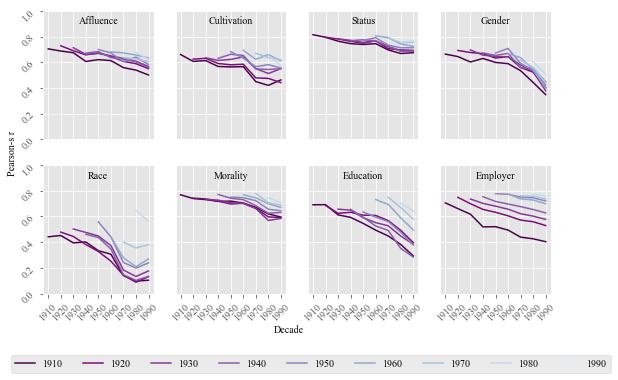

In [21]:
self = histwords_iter
from matplotlib import cm
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (9.094437525944375,5.2))
fig.text(0.5, 0.02, 'Decade', ha='center')
fig.text(0.07, 0.5, 'Pearson-s r', va='center', rotation='vertical')
plt.style.use("ggplot")
rdpu = cm.get_cmap('BuPu', 10)
colours = rdpu(range(10))

plt.rcParams["font.family"] = "Times New Roman"

dims = self.dims
print(dims)
for i,dim in enumerate(dims):
    if i == 7:
        fig.legend([1910+10*i for i in range(9)], loc='lower right', bbox_to_anchor=(1,-0.1), ncol=9, bbox_transform=fig.transFigure)
    done_decs = []
    j = 0
    for dec, wv in self.wvs.items():
        done_decs.append(dec)
        x = [deca for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
        y = [val for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
        ax[i//4, i%4].plot(x,y, color = colours[9-j], label = dec)
        
      
        ax[i//4, i%4].tick_params(axis='x', which='major', labelsize=10)
        ax[i//4, i%4].tick_params(axis='y', which='major', labelsize=10)
        ax[i//4, i%4].set_ylim([0, 1])
        ax[i//4, i%4].tick_params(labelrotation=45)
        if i//4 != 1:
            ax[i//4, i%4].tick_params(axis="x", colors ='white') 
        if i % 4 != 0:
            ax[i//4, i%4].tick_params(axis="y", colors ='white') 
        #ax[i//2, i%2].legend(shadow=True, fancybox=True)
      #  ax[i//2, i%2].tick_params(axis='both', which='minor', labelsize=8)
        #fig.legend(handles, labels, loc='lower right')
        
        tit = str(dim).title()
        ax[i//4, i%4].set_title(tit, y=0.85, fontsize=10)
     #   ax[i//2, i%2]..titlesize
        j+=1
plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/dimension_stability.jpg", dpi=400, bbox_inches = "tight")


In [251]:
#end result: top_n most similar each dimension pole (pos/neg), their value @ 1900 and 1990
self = histwords_iter
topn = 10000
selectn = 5
similars = {}
similar_vals = {}
for dim in self.dims:
    similars[dim] = {}
    similar_vals[dim] = {}
    for dec in ["1900", "1990"]:
        similars[dim][dec] = []
        similar_vals[dim][dec] = []
        vec = self.dim_vecs[dec][dim]
        pos = self.ants[dec][dim].iloc[:,-2]
        neg = self.ants[dec][dim].iloc[:,-1]
        pos_list = []
        neg_list = []
        for i in range(len(pos)):
            try:
                n = self.wvs[dec][neg[i]]
                p = self.wvs[dec][pos[i]]
                pos_list.append(pos[i])
                neg_list.append(neg[i])
            except:
                continue
   #     print(dim, dec, self.wvs[dec].most_similar(positive = neg_list, topn=5))
        pos_sims = [word[0] for word in self.wvs[dec].most_similar(positive = pos_list, negative = neg_list, topn = topn)]
        neg_sims = [word[0] for word in self.wvs[dec].most_similar(positive = neg_list, negative = pos_list, topn = topn)]
        #similars[dim][dec]["positive"] = pos_sims
       # similars[dim][dec]["negative"] = neg_sims
        similars[dim][dec] = pos_sims[:selectn] + neg_sims[:selectn]
     #   print(dim, dec, pos_list, neg_list, similars[dim][dec] )
        s = 0
        for word in similars[dim][dec]:
            if s > selectn-1:
                break
            point = []
            for deca in ["1900","1990"]:
               # print(word, self.wvs[deca].n_similarity([word], pos_list))
                point.append(self.wvs[deca].n_similarity([word], pos_list))
            if point[0] == 0 or point[1] == 0:
               # print(dim, dec, word)
                continue
            similar_vals[dim][dec].append(point)
            s += 1
        
    

In [253]:
similar_vals

{'affluence': {'1900': [], '1990': []},
 'cultivation': {'1900': [], '1990': []},
 'status': {'1900': [],
  '1990': [[0.48433965, 0.46821785],
   [0.42592245, 0.4702596],
   [0.4235655, 0.4686481],
   [0.33442268, 0.38876522],
   [0.47252837, 0.4512906]]},
 'gender': {'1900': [[0.0032206886, 0.042437553],
   [0.0028932933, -0.046923187],
   [0.12930073, 0.06882226],
   [-0.039137244, 0.08887209],
   [0.4275753, 0.4501922]],
  '1990': [[0.044760853, 0.119399235],
   [0.02853683, 0.16562936],
   [0.030452492, 0.1490483],
   [-0.046764575, 0.12478151],
   [0.053358875, 0.1753363]]},
 'race': {'1900': [[0.3498218, 0.26622295],
   [0.32500902, 0.24651387],
   [0.23968473, 0.33442312],
   [0.32841867, 0.3495521],
   [0.18887907, 0.008471962]],
  '1990': [[0.23968473, 0.33442312],
   [0.19242977, 0.3632797],
   [-0.074585415, 0.09220351],
   [0.16491655, 0.22609854],
   [0.11317682, 0.039860595]]},
 'morality': {'1900': [], '1990': []},
 'education': {'1900': [],
  '1990': [[0.48078418, 0.480

# Individual lifestyle domain GoC correlations

In [306]:
def corr_survey(self, model, groups):
        survey = pd.read_csv("G:/My Drive/KU/Thesis/data/survey_data/survey_means_weighted.csv")
        survey = survey.rename(columns= {"Unnamed: 0": "words"})
        survey = survey.set_index("words")
        cats =  ["race", "gender", "affluence"]
        
        ant_pairs = {}
        vals = {}
        projs = {}
        dims = {}
        embed = self.models[model]
        for group, items in groups.items():
            items = [item.lower() for item in items]
            vals[group] = {}
            for cat in cats:
                ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
                ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
                #prepare dictionaries for survey & projection values
                vals[group][cat + "_survey"] = {}
                vals[group][cat + "_proj"] = {}
                #calculate dimensions from antonym pairs
                dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
                #project embeddings onto dimension
                projs[cat] = self.proj_dim(model, dims[cat])
                #iterate through words
                not_in_vocab = []
                for row in survey.iterrows():
                    word = row[0].lower()
                    if word not in items:
                       # print(word, items)
                        continue
                    try:
                        #print(word)
                        #retrieve index in embeddings
                        ind = embed.get_index(word)
                        #retrieve projected value using index
                        val = projs[cat][ind]
                        #add all to DF
                        vals[group][cat + "_survey"][word] = row[1][cat + "_mean"]
                        vals[group][cat + "_proj"][word] = val
                    except Exception as e:
                        not_in_vocab.append(word)

          #  print(f"{not_in_vocab} not in embeddings vocab!")
        self.vals = vals#pd.DataFrame(vals)
        corrs = {group: {} for group in groups.keys()}
        print(vals)
        for group, items in groups.items():
            for cat in ["race", "gender", "affluence"]:
                #print(self.vals[group][cat + "_survey"], self.vals[group][cat + "_proj"])
                corrs[group][cat + "_survey_corr"] = pearsonr(list(self.vals[group][cat + "_survey"].values()), list(self.vals[group][cat + "_proj"].values()))    
               # corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs
coll = "histwords_engall"
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_iter = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=True, dl=False)
eval_iter.load_wv(decade_files[-1])
#print(eval_iter.corr_census(decade_files[-1]))
corr_survey(eval_iter, decade_files[-1], domain_dic["goc_culture_domains"])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:156: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


{'Occupations': {'race_survey': {'hairdresser': 50.86118, 'lawyer': 35.66758, 'doctor': 37.82003, 'plumber': 39.27434, 'scientist': 32.74435, 'engineer': 32.92745, 'banker': 32.65704, 'nanny': 41.04066, 'carpenter': 42.08532, 'journalist': 39.90278, 'nurse': 43.68505}, 'race_proj': {'hairdresser': 0.070591584, 'lawyer': -0.0779458, 'doctor': 0.042965513, 'plumber': 0.05737286, 'scientist': -0.14644775, 'engineer': -0.09468469, 'banker': -0.05657224, 'nanny': 0.03622751, 'carpenter': 0.021289663, 'journalist': -0.14413749, 'nurse': -0.09299795}, 'gender_survey': {'hairdresser': 20.6902, 'lawyer': 61.77906, 'doctor': 60.06721, 'plumber': 80.25067, 'scientist': 61.87003, 'engineer': 69.79498, 'banker': 59.9074, 'nanny': 17.65112, 'carpenter': 80.9367, 'journalist': 47.79544, 'nurse': 26.29599}, 'gender_proj': {'hairdresser': 0.12751889, 'lawyer': 0.10730245, 'doctor': -0.03549278, 'plumber': 0.03289957, 'scientist': 0.05337469, 'engineer': 0.14826168, 'banker': 0.028463397, 'nanny': -0.01

{'Occupations': {'race_survey_corr': (0.544162270493768, 0.08352819710506733),
  'gender_survey_corr': (0.3488782673616875, 0.29300407890874536),
  'affluence_survey_corr': (0.10986557881846865, 0.7477795357055855)},
 'Clothing': {'race_survey_corr': (0.08063172585474714, 0.824760375859423),
  'gender_survey_corr': (0.6586505658896284, 0.03835945683596249),
  'affluence_survey_corr': (0.2596915212867243, 0.46871030076675635)},
 'Sports': {'race_survey_corr': (-0.13797113506799163, 0.7233481583077811),
  'gender_survey_corr': (-0.08468865673353053, 0.8285015165326973),
  'affluence_survey_corr': (-0.11429302512422897, 0.7696838771365931)},
 'Music Genres': {'race_survey_corr': (-0.5637014761234259,
   0.24400849431755847),
  'gender_survey_corr': (0.5852844507371021, 0.22232022663658643),
  'affluence_survey_corr': (0.9440859444592907, 0.004602168073106391)},
 'Vehicles': {'race_survey_corr': (0.4311938588247922, 0.5688061411752078),
  'gender_survey_corr': (-0.05124460065375383, 0.9487

In [324]:
ext = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_external_models.csv",header=0, index_col = 0).round(2)

print(df.to_latex("external_mods_eval.tex"))
df.columns = ['Fasttext Wiki News 300', 'GloVe Twitter 100',
       'GloVe Twitter 200', 'GloVe Twitter 25', 'GloVe Twitter 50',
       'GloVe Wiki 100', 'GloVe Wiki 200',
       'GloVe Wiki 300', 'GloVe Wiki 50',
       'Word2Vec 300']
df

None


,Fasttext Wiki News 300,GloVe Twitter 100,GloVe Twitter 200,GloVe Twitter 25,GloVe Twitter 50,GloVe Wiki 100,GloVe Wiki 200,GloVe Wiki 300,GloVe Wiki 50,Word2Vec 300
analogy_score,0.88,0.46,0.57,0.13,0.29,0.63,0.70,0.72,0.46,0.74
word_pair_pearson,0.61,0.52,0.53,0.36,0.47,0.55,0.58,0.60,0.51,0.62
word_pair_pearson_p_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
word_pair_spearman,0.60,0.51,0.52,0.36,0.46,0.53,0.58,0.61,0.50,0.66
word_pair_spearman_p_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
race_survey_corr,-0.56,-0.35,-0.32,-0.09,-0.23,-0.10,-0.38,-0.43,-0.04,-0.52
gender_survey_corr,0.88,0.77,0.83,0.40,0.62,0.79,0.87,0.86,0.73,0.80
affluence_survey_corr,0.49,0.14,0.30,0.04,0.06,0.28,0.52,0.55,0.38,0.49


In [ ]:
import scipy.stats as st
#data = list of data points
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

In [244]:
self.wvs["1900"].most_similar(positive=self.ants["1900"]["affluence"].iloc[:,-2])

KeyError: "Key 'classy' not present"

In [250]:
similars
similar_vals = {}
for dim in self.dims:
    similar_vals[dim] = {}
    for dec in ["1900", "1990"]:
        similar_vals[dim][dec] = []